In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
WITH_SERVICE_AUTHENTICATION = 'WITH_SERVICE_AUTHENTICATION'
WITH_CLIENT_AUTHENTICATION = 'WITH_CLIENT_AUTHENTICATION'
NO_SOMEIP_SD = 'NO_SOMEIP_SD'
WITH_DNSSEC = 'WITH_DNSSEC'
WITH_DANE = 'WITH_DANE'
WITH_ENCRYPTION = 'WITH_ENCRYPTION'

STATISTICS_PARENT_PATH='/home/mehmet/vscode-workspaces/mininet-vsomeip/statistic-results'

compile_definitions = {'A':'Vanilla',
                        'B':f'{NO_SOMEIP_SD} {WITH_DNSSEC}',
                        'C':f'{WITH_SERVICE_AUTHENTICATION}',
                        'D':f'{NO_SOMEIP_SD} {WITH_SERVICE_AUTHENTICATION} {WITH_DNSSEC} {WITH_DANE}',
                        'E':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION}',
                        'F':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION} {WITH_ENCRYPTION}',
                        'G':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION} {WITH_DNSSEC} {WITH_DANE}',
                        'H':f'{WITH_SERVICE_AUTHENTICATION} {WITH_CLIENT_AUTHENTICATION} {WITH_DNSSEC} {WITH_DANE} {WITH_ENCRYPTION}'}

In [37]:
# fig, ax = plt.subplots(4, 2, figsize=(30, 20))
# row = 0
# column = 0
# for option, description in compile_definitions.items():
#     evaluation_option = option
#     member_count = 1
#     ax[row, column].set_title(f"{option}: {description}")
#     ax[row, column].set_ylabel('Duration [ms]')

#     file_count = 0
#     filename = f'{STATISTICS_PATH}/{evaluation_option}-{member_count}-#{file_count}.csv'
#     discovery_latency: list = list()
#     subscription_latency: list = list()
#     while Path(filename).is_file():
#         df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
#         if NO_SOMEIP_SD in description:
#             discovery_upper_bound = 'SVCB_SERVICE_RESPONSE_RECEIVE'
#         else:
#             discovery_upper_bound = 'OFFER_RECEIVE'
#         subscription_lower_bound = discovery_upper_bound
#         if WITH_SERVICE_AUTHENTICATION in description:
#             subscription_upper_bound = 'VERIFY_SERVICE_SIGNATURE_END'
#         else:
#             subscription_upper_bound = 'SUBSCRIBE_ACK_RECEIVE'
#         discovery_latency.append(df[discovery_upper_bound].max()/1000_000 - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000)
#         subscription_latency.append(df[subscription_upper_bound].max()/1000_000 - df[subscription_lower_bound].min()/1000_000)
#         file_count += 1
#         filename = f'{STATISTICS_PATH}/{evaluation_option}-{member_count}-#{file_count}.csv'
#     ax[row, column].boxplot([discovery_latency, subscription_latency])
#     ax[row, column].set_xticklabels(labels=['discovery_latency', 'subscription_latency'], rotation=0)
#     column += 1
#     if not (column % 2):
#         column = 0
#         row += 1
# plt.show()


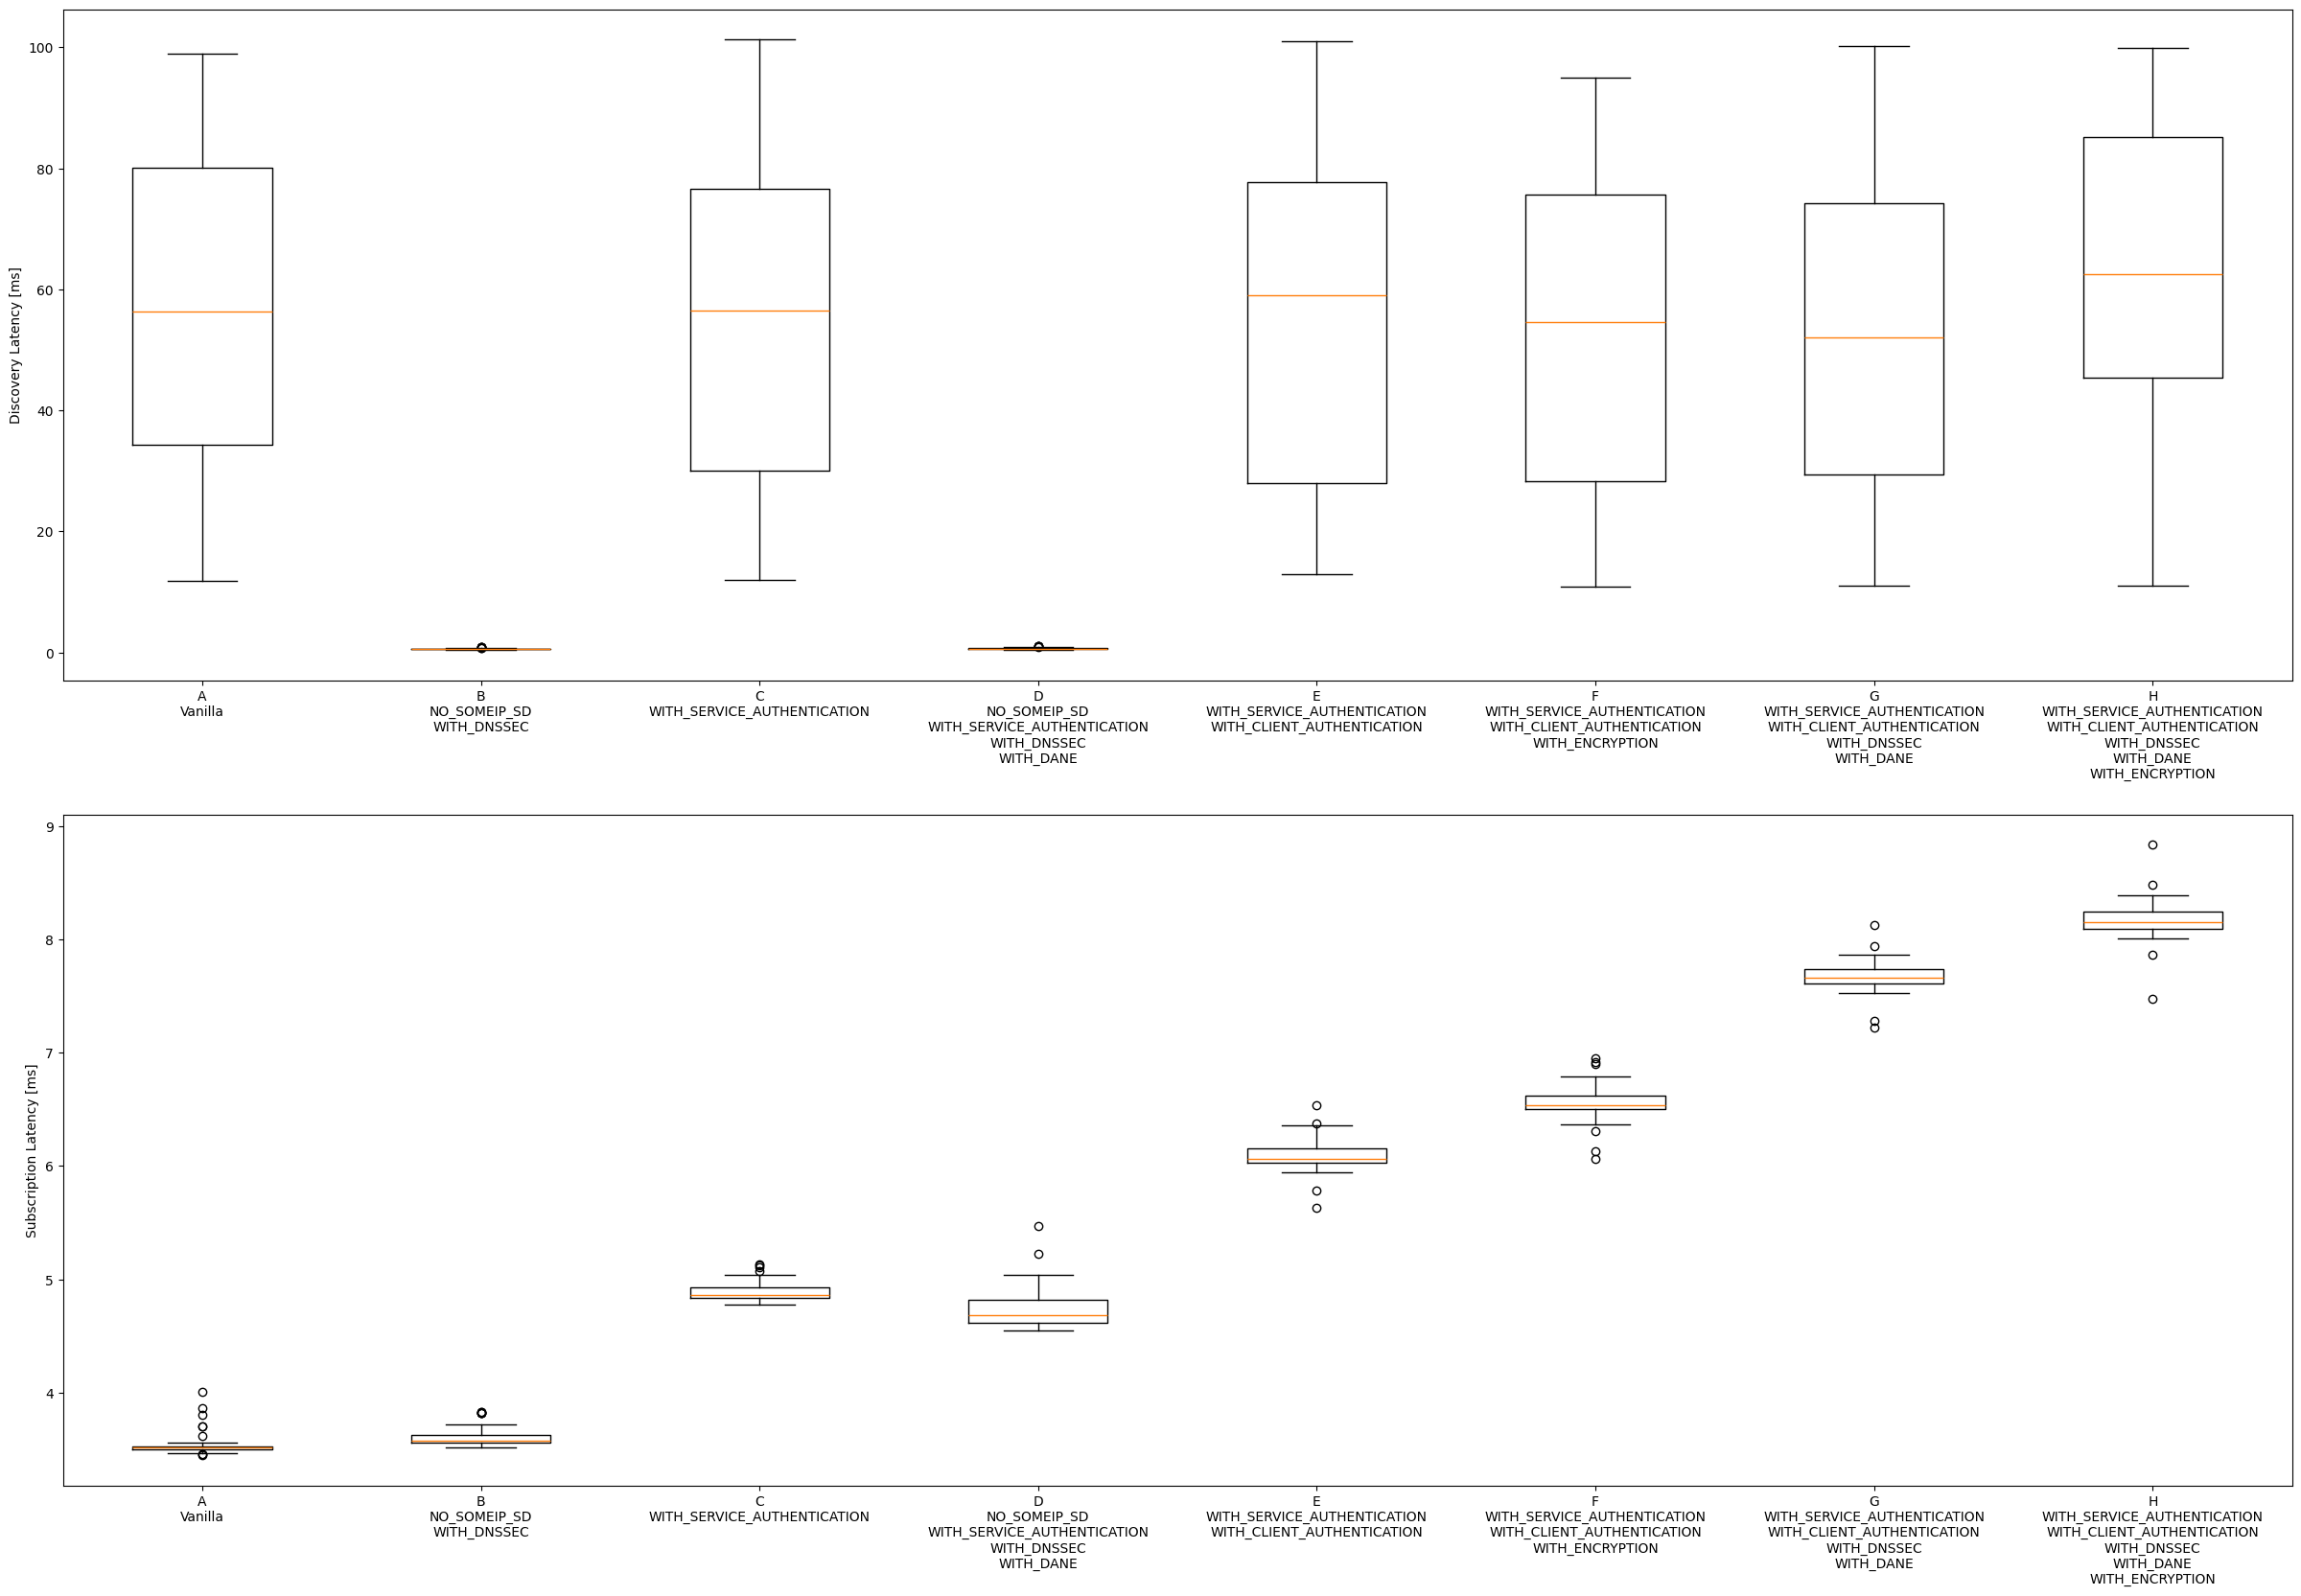

In [3]:
discovery_latency_dict: dict() = dict()
subscription_latency_dict: dict() = dict()
fig, ax = plt.subplots(2, 1, figsize=(30, 20))
title: str() = ''

box_labels: list() = list()


ax[0].set_ylabel('Discovery Latency [ms]')
ax[1].set_ylabel('Subscription Latency [ms]')

for option, description in compile_definitions.items():
    evaluation_option = option
    member_count = 1
    description_list = description.split()
    box_labels.append(option+'\n'+'\n'.join(description_list))

    file_count = 0
    filename = f'{STATISTICS_PARENT_PATH}/1xpublisher-1xsubscriber/{evaluation_option}-{member_count}-#{file_count}.csv'
    discovery_latency: list = list()
    subscription_latency: list = list()
    while Path(filename).is_file():
        df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
        if NO_SOMEIP_SD in description:
            discovery_upper_bound = 'SVCB_SERVICE_RESPONSE_RECEIVE'
        else:
            discovery_upper_bound = 'OFFER_RECEIVE'
        subscription_lower_bound = discovery_upper_bound
        if WITH_SERVICE_AUTHENTICATION in description:
            subscription_upper_bound = 'VERIFY_SERVICE_SIGNATURE_END'
        else:
            subscription_upper_bound = 'SUBSCRIBE_ACK_RECEIVE'
        discovery_latency.append(df[discovery_upper_bound].max()/1000_000 - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000)
        subscription_latency.append(df[subscription_upper_bound].max()/1000_000 - df[subscription_lower_bound].min()/1000_000)
        file_count += 1
        filename = f'{STATISTICS_PARENT_PATH}/1xpublisher-1xsubscriber/{evaluation_option}-{member_count}-#{file_count}.csv'
    discovery_latency_dict[option] = discovery_latency
    subscription_latency_dict[option] = subscription_latency
ax[0].boxplot(discovery_latency_dict.values())
ax[0].set_xticklabels(labels=box_labels, rotation=0)
ax[1].boxplot(subscription_latency_dict.values())
ax[1].set_xticklabels(labels=box_labels, rotation=0)
# plt.subplots_adjust(hspace=0.4)
plt.show()

In [16]:
import statistics

option = 'A'
member_count = 1
file_count = 4
filename = f'{STATISTICS_PARENT_PATH}/{option}-{member_count}-#{file_count}.csv'
discovery_latency: list = list()
subscription_latency: list = list()
if Path(filename).is_file():
    df = pd.read_csv(filepath_or_buffer=filename, header=0, sep=',', dtype=np.longlong)
    discovery_latency.append(df['OFFER_RECEIVE'].max()/1000_000 - df['SUBSCRIBER_APP_INITIALIZATION_END'].min()/1000_000)
    subscription_latency.append(df['SUBSCRIBE_ACK_RECEIVE'].max()/1000_000 - df['OFFER_RECEIVE'].min()/1000_000)
    # file_count += 1
    # filename = f'{STATISTICS_PARENT_PATH}/{option}-{member_count}-#{file_count}.csv'
print(f'DISCOVERY LATENCY {max(discovery_latency)}')
print(f'SUBSCRIPTION LATENCY {max(subscription_latency)}')

DISCOVERY LATENCY 1026.234130859375
SUBSCRIPTION LATENCY 7024.560546875
